In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import os
import gc
import warnings
import random

# For EDA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# Configurations
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor

In [2]:
train = pd.read_csv("/Users/vaidehiparikh/Downloads/IDMP/IDMP Project/store-sales-time-series-forecasting/train.csv")
oil = pd.read_csv("/Users/vaidehiparikh/Downloads/IDMP/IDMP Project/store-sales-time-series-forecasting/oil.csv")
holidays = pd.read_csv("/Users/vaidehiparikh/Downloads/IDMP/IDMP Project/store-sales-time-series-forecasting/holidays_events.csv")
stores = pd.read_csv("/Users/vaidehiparikh/Downloads/IDMP/IDMP Project/store-sales-time-series-forecasting/stores.csv")

In [3]:
# Merging the data
df = train.merge(oil, on = 'date', how='left')
df = df.merge(holidays, on = 'date', how='left')
df = df.merge(stores, on = 'store_nbr', how='left')
df = df.rename(columns = {"type_x" : "holiday_type", 
                                  "type_y" : "store_type"})

In [4]:
# Resampled with dates
df = df.rename(columns={"dcoilwtico": "Oil_Price"})

# Interpolate
df["Oil_Price"] = np.where(df["Oil_Price"] == 0, np.nan, df["Oil_Price"])
df["Oil_Price_interpolated"] =df.Oil_Price.interpolate(method ='linear', limit_direction ='backward')

In [5]:
df["date"] = pd.to_datetime(df.date)

In [6]:
# Filtering Data based on family to consider 'Grocery I'
df1 = df[df['family'] == 'GROCERY I']

In [7]:
def mape(Y_actual, y_forecasted):
    val = np.mean(np.abs((Y_actual - y_forecasted)/Y_actual))*100
    return val

In [8]:
#performing a group by on date and taking the sum of sales
df2 = df1.groupby('date')['sales'].sum()
df2=df2.reset_index()

In [9]:
#performing a group by on date and taking the sum of sales
df3 = df1.groupby('date')['Oil_Price_interpolated'].sum()
df3 = df3.reset_index()

In [10]:
#performing a group by on date and taking the sum of sales
df4 = df1.groupby('date')['onpromotion'].sum()
df4 = df4.reset_index()

In [11]:
df2 = df2.merge(df3, on = 'date', how='left')
df2 = df2.merge(df4, on = 'date', how='left')
df2.shape

(1684, 4)

In [12]:
df2 = df2.set_index('date')

In [13]:
# Set four weeks for testing
train = df2.iloc[:1457]
test = df2.iloc[1457:]

In [14]:
test

,sales,Oil_Price_interpolated,onpromotion
date,,,
2017-01-01,1998.00,2865.03,63
2017-01-02,415182.95,2840.01,4926
2017-01-03,321085.26,2827.44,4843
2017-01-04,274170.60,2876.04,6257
2017-01-05,226863.18,2903.58,2575
...,...,...,...
2017-08-11,238221.92,2635.74,2349
2017-08-12,238627.63,2619.34,2325
2017-08-13,258442.45,2586.41,2320


In [15]:
train_y = train.drop(['Oil_Price_interpolated', 'onpromotion'], axis = 1)
train_x = train[['Oil_Price_interpolated', 'onpromotion']]

In [16]:
train_y

,sales
date,
2013-01-01,700.00
2013-01-02,202020.00
2013-01-03,144878.00
2013-01-04,135754.00
2013-01-05,188356.00
...,...
2016-12-27,242792.09
2016-12-28,265759.51
2016-12-29,257006.74


In [17]:
test_y = test.drop(['Oil_Price_interpolated', 'onpromotion'], axis = 1)
test_x = test[['Oil_Price_interpolated', 'onpromotion']]

In [18]:
regressor = LinearRegression()
regressor.fit(train_x,train_y)
test['pred_LR'] = regressor.predict(test_x)

In [19]:
test

,sales,Oil_Price_interpolated,onpromotion,pred_LR
date,,,,
2017-01-01,1998.00,2865.03,63,177624.97
2017-01-02,415182.95,2840.01,4926,306493.88
2017-01-03,321085.26,2827.44,4843,304273.92
2017-01-04,274170.60,2876.04,6257,341832.74
2017-01-05,226863.18,2903.58,2575,244273.72
...,...,...,...,...
2017-08-11,238221.92,2635.74,2349,237861.15
2017-08-12,238627.63,2619.34,2325,237199.13
2017-08-13,258442.45,2586.41,2320,237014.73


[Text(0.5, 0, ''), Text(0, 0.5, 'Visitors per day')]

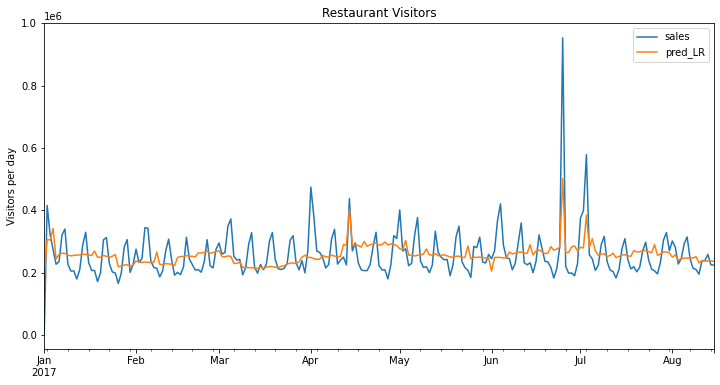

In [20]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['sales'].plot(legend=True,figsize=(12,6),title=title)
test['pred_LR'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [21]:
# Evaluating the model
error1 = mape(test['sales'], test['pred_LR'])

print(' MAPE for Linear Regression: ', error1)

 MAPE for Linear Regression:  56.299711091114204


In [22]:
RFR = RandomForestRegressor()
RFR.fit(train_x,train_y)
test['pred_RF'] = RFR.predict(test_x)

[Text(0.5, 0, ''), Text(0, 0.5, 'Visitors per day')]

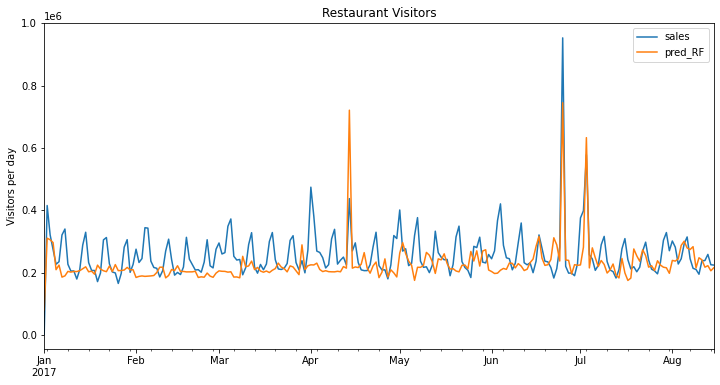

In [23]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['sales'].plot(legend=True,figsize=(12,6),title=title)
test['pred_RF'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [24]:
# Evaluating the model
error2 = mape(test['sales'], test['pred_RF'])

print(' MAPE for Random Forest: ', error2)

 MAPE for Random Forest:  34.89779424191854


In [25]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 2021
seed_everything(SEED)

In [26]:
BR2 = BaggingRegressor(base_estimator=RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=SEED),
                                  n_estimators=10,
                                  n_jobs=-1,
                                  random_state=SEED) 
BR2.fit(train_x, train_y)
test['pred_BR'] = BR2.predict(test_x)

[Text(0.5, 0, ''), Text(0, 0.5, 'Visitors per day')]

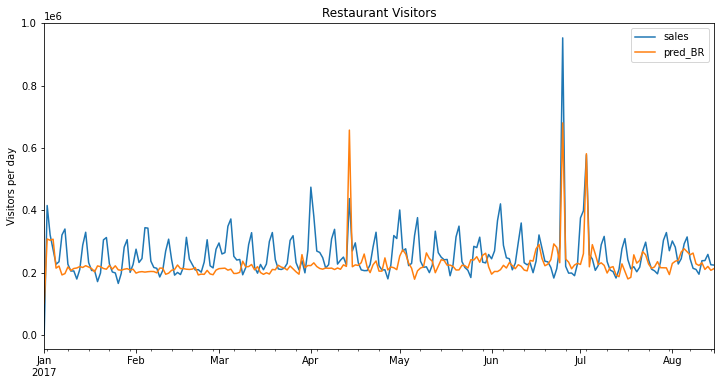

In [27]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['sales'].plot(legend=True,figsize=(12,6),title=title)
test['pred_BR'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [28]:
# Evaluating the model
error3 = mape(test['sales'], test['pred_BR'])

print(' MAPE for Bagging Regressor: ', error3)

 MAPE for Bagging Regressor:  38.339315799292116


In [29]:
EXT = ExtraTreesRegressor(n_estimators=500, n_jobs=-1, random_state=SEED) 
EXT.fit(train_x, train_y)
test['pred_EXT'] = EXT.predict(test_x)

[Text(0.5, 0, ''), Text(0, 0.5, 'Visitors per day')]

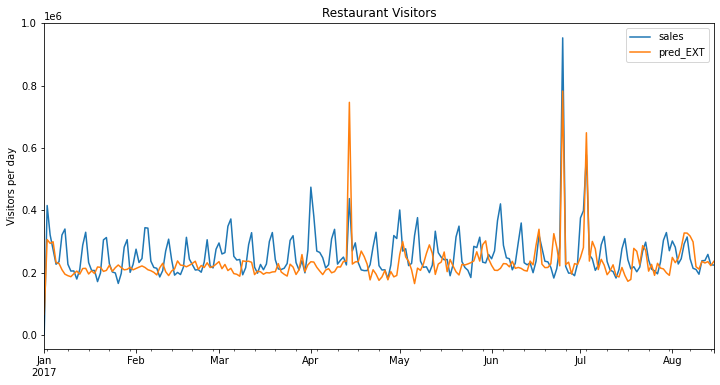

In [30]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['sales'].plot(legend=True,figsize=(12,6),title=title)
test['pred_EXT'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [31]:
# Evaluating the model
error4 = mape(test['sales'], test['pred_EXT'])

print(' MAPE for Extra Tree Regressor: ', error4)

 MAPE for Extra Tree Regressor:  31.738256916486307
